# Example iPython Code for the CosmicWatch Muon Detector

This script can be used to make some simple plots using iPython.
You'll require some imports, all of which are in the next cell.

This script is adapted from the Example iPython Notebook provided in the original CosmicWatch v2 GitHub.

In [1]:
%pip install numpy matplotlib ipython spicy

Note: you may need to restart the kernel to use updated packages.


In [2]:
#***************
# Master import
#***************

# Plot data in the window
%matplotlib inline
# Make the cell width the size of the window
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Imports
import glob
import sys
#import nplot as NPlot ##added
import pylab
from pylab import *
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import time
import numpy as np
import os

# Fontsize
font = { 'size':   24}
matplotlib.rc('font', **font)

'''
# Allow it to use Latex notation
plt.rc('text', usetex=True)
'''
# Define your own colors for the plots
mycolors = ['#c70039','#ff5733','#ff8d1a','#ffc300','#eddd53','#add45c','#57c785',
               '#00baad','#2a7b9b','#3d3d6b','#511849','#900c3f','#900c3f'] 

#***************
# Master import
#***************
print('Imports complete ...')

Imports complete ...


In [3]:
# ***********************************************************************************
# CWClass
# This class is used to import CW data and use it easily. It will use either the 
# data recorded by the computer or from the microSD Card.
#
# Arguments:
#    1. fname: 
#       location and name of the file that you want to plot
#    2. bin_size:
#       When plotting rate as a function of time, you need to specify the rate over
#       a given interval. "bin_size" is the interval in seconds. Default is 60s.
#***********************************************************************************

class CWClass():
    def __init__(self,fname,bin_size = 60):
        self.name = fname.split('/')[-1]
        self.bin_size = bin_size
        
        fileHandle = open(fname,"r" )
        lineList = fileHandle.readlines()
        fileHandle.close()
        header_lines = 0
        
        # Look through the first 1000 lines for the word "Device". Everything prior is considered part of the header.
        for i in range(min(len(lineList),1000)):
            header_in_file = lineList[i]
            if 'Device' in header_in_file:
                header_lines = i+1
  
        #Determine number of columns by looking at the second last line in the file.
        number_of_columns = len(lineList[len(lineList)-2].split(" "))
        column_array = range(0,number_of_columns)

        
        file_from_computer = False
        file_from_sdcard   = False
        
        if number_of_columns == 9:
            file_from_computer = True  # If you have 9 columns, you probably took the data on the computer 
            data = np.genfromtxt(fname, dtype = str, delimiter=' ', usecols=column_array, invalid_raise=False, skip_header=header_lines)
            comp_date = data[:,0] #first column of data
            comp_time = data[:,1]
            event_number = data[:,2].astype(float) #replace np.float w just float 
            Ardn_time_ms = data[:,3].astype(float) #
            adc = data[:,4].astype(float)#
            sipm = data[:,5].astype(float)#
            deadtime = data[:,6].astype(float)#
            temperature = data[:,7].astype(float)#
            detName = data[:,8]
            
        elif number_of_columns == 6:
            file_from_sdcard = True # If you have 6 columns, you took the data from the sdCard
            data = np.genfromtxt(fname, dtype = str, delimiter=' ', usecols=column_array, invalid_raise=False, skip_header=header_lines)
            event_number = data[:,0].astype(float)#
            Ardn_time_ms = data[:,1].astype(float)
            adc = data[:,2].astype(float)
            sipm = data[:,3].astype(float)
            deadtime = data[:,4].astype(float)
            temperature = data[:,5].astype(float)#
            
        else: 
            print('The file format is unknown, or older. If it is an older file format, you will have to change the number of columns in the CW class.')
            
            
        # Simple check to see if the events are sequential
        def sequential(l):
            l = np.asarray(l).astype(int) #replaced np.int with int
            check = range(min(l),max(l)+1)

            if len(l)!=len(check):
                print('There is an event missing in the data.')
                return False

            counter = 0
            for i in range(len(l)):
                counter+=1
                if l[i]!=check[i]:
                    print('Check event number: '+str(counter))
            return sum(check == l)==len(l)

        if not sequential(event_number):
            print('Events in file are not sequential.')

        # Convert the computer time to an absolute time (MJD).
        if file_from_computer:
            time_stamp = []
            for i in range(len(comp_date)):
                year  = int(comp_date[i].split('-')[0])
                month = int(comp_date[i].split('-')[1])
                day   = int(comp_date[i].split('-')[2])
                hour  = int(comp_time[i].split(':')[0])
                mins  = int(comp_time[i].split(':')[1])
                sec   = int(np.floor(float(comp_time[i].split(':')[2])))
                try:  
                    decimal = float('0.'+str(comp_time[i].split('.')[-1]))
                except:
                    decimal = 0.0
                time_stamp.append(float(time.mktime((year, month, day, hour, mins, sec, 0, 0, 0)))+ decimal) 


            self.time_stamp_s     = np.asarray(time_stamp) -  min(np.asarray(time_stamp))       # The absolute time of an event in seconds
            self.time_stamp_ms    = np.asarray(time_stamp -  min(np.asarray(time_stamp)))*1000  # The absolute time of an event in miliseconds   
            self.total_time_s     = max(time_stamp) -  min(time_stamp)     # The absolute time of an event in seconds
            #self.detector_name    = detName                                
            #self.n_detector       = len(set(detName))

        # Convert the cumulative deadtime to the deadtime between events
        # The detector starts at time 0, so append a zero.
        event_deadtime_ms = diff(np.append([0],deadtime))

        # The Arduino absolute time isn't great. Over the course of a few hours, it will be off by several seconds. 
        # The computer will give you accurate time down to about 1ms. Reading from the serial port has ~ms scale uncertainty.
        # The Arduino can give you a precise measurement (down to 1us), but the absolute time will drift. Expect it to be off by roughly 1min per day.
        self.Ardn_time_ms      = Ardn_time_ms
        self.Ardn_time_s       = Ardn_time_ms/1000.
        
        self.Ardn_total_time_s = max(self.Ardn_time_s)
        self.Ardn_total_time_ms= max(self.Ardn_time_s)*1000.

        self.event_number     = np.asarray(event_number)  # an arrray of the event numbers
        self.total_counts     = max(event_number.astype(int)) - min(event_number.astype(int))
        self.adc              = adc         # an arrray of the measured event ADC value
        self.sipm             = sipm        # an arrray of the measured event SiPM value
        
        self.event_deadtime_s   = event_deadtime_ms/1000.      # an array of the measured event deadtime in seconds
        self.event_deadtime_ms  = event_deadtime_ms            # an array of the measured event deadtime in miliseconds
        self.total_deadtime_ms  = max(event_deadtime_ms)       # an array of the measured event deadtime in miliseconds
        self.total_deadtime_s   = max(event_deadtime_ms)/1000. # The total deadtime in seconds
                
        # The time between events is well described by the Arduino timestamp. 
        # The 'diff' command takes the difference between each element in the array.
        self.Ardn_event_livetime_s = diff(np.append([0],self.Ardn_time_s)) - self.event_deadtime_s
        

        if file_from_computer:
            self.live_time        = (self.total_time_s - self.total_deadtime_s)
            self.weights          = np.ones(len(event_number)) / self.live_time
            self.count_rate       = self.total_counts/self.live_time 
            self.count_rate_err   = np.sqrt(self.total_counts)/self.live_time 

            bins = range(0,int(max(self.time_stamp_s)), self.bin_size)
            counts, binEdges       = np.histogram(self.time_stamp_s, bins = bins)
            bin_livetime, binEdges = np.histogram(self.time_stamp_s, bins = bins, weights = self.Ardn_event_livetime_s)
        
        elif file_from_sdcard:
            self.live_time        = (self.Ardn_total_time_ms - self.total_deadtime_ms)/1000.
            self.weights          = np.ones(len(event_number)) / self.live_time
            self.count_rate       = self.total_counts/self.live_time 
            self.count_rate_err   = np.sqrt(self.total_counts)/self.live_time 

            bins = range(int(min(self.Ardn_time_s)),int(max(self.Ardn_time_s)),self.bin_size)
            counts, binEdges = np.histogram(self.Ardn_time_s, bins = bins)
            bin_livetime, binEdges = np.histogram(self.Ardn_time_s, bins = bins, weights = self.Ardn_event_livetime_s)
            
        else:
            print('Error')
        
        print('Count rate: '+str(np.round(self.count_rate,4)) +' +/- '+ str(np.round(self.count_rate_err,4)))
        
        bincenters = 0.5*(binEdges[1:]+ binEdges[:-1])
        
        self.bin_size          = bin_size
        self.binned_counts     = counts
        self.binned_counts_err = np.sqrt(counts)
        self.binned_count_rate = counts/bin_livetime
        self.binned_count_rate_err = np.sqrt(counts)/bin_livetime
        self.binned_time_s     = bincenters
        self.binned_time_m     = bincenters/60.

    
        
def plusSTD(n,array):
    xh = np.add(n,np.sqrt(np.abs(array)))
    return xh

def subSTD(n,array):
    xl = np.subtract(n,np.sqrt(np.abs(array)))
    return xl

def fill_between_steps(x, y1, y2=0, h_align='mid', ax=None,lw=2, **kwargs):
    # If no Axes opject given, grab the current one:
    if ax is None:
        ax = plt.gca()
    # First, duplicate the x values
    xx = x.repeat(2)[1:]
    # Now: the average x binwidth
    xstep = np.repeat((x[1:] - x[:-1]), 2) #swap sp for np
    xstep = np.concatenate(([xstep[0]], xstep, [xstep[-1]])) #swap sp for np
    # Now: add one step at end of row.
    xx = np.append(xx, xx.max() + xstep[-1])

    # Make it possible to chenge step alignment.
    if h_align == 'mid':
        xx -= xstep / 2.
    elif h_align == 'right':
        xx -= xstep

    # Also, duplicate each y coordinate in both arrays
    y1 = y1.repeat(2)#[:-1]
    if type(y2) == np.ndarray: ##sp to np
        y2 = y2.repeat(2)#[:-1]

    # now to the plotting part:
    ax.fill_between(xx, y1, y2=y2,lw=lw, **kwargs)
    return ax

print('Definitions complete ...')

Definitions complete ...


# Angle Plot

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pylab

class anglePlot:
    def __init__(self,
                 angles,            # list of angles in degrees
                 count_rates,       # list of count rates
                 count_rates_err,   # list of errors in count rates
                 figsize=[8, 6],
                 fontsize=18,
                 alpha=0.9,
                 loc=1,
                 pdf_name=''):

        # Initialize figure
        fig = plt.figure(figsize=figsize)
        ax1 = fig.add_subplot(111)

        # Reference curve: cos^2(theta)
        x = np.linspace(-0.020, np.pi, 100)
        y = np.cos(x) ** 2

        # Convert angles to radians
        angles = np.asarray(angles) * np.pi / 180.

        # Compute angle errors and normalized rates
        angles_err = [6 * np.pi / 180.] * len(angles)  # Half of 12 degrees in radians
        normalized_rates = np.asarray(count_rates) / max(count_rates)
        count_rates_err = np.asarray(count_rates_err) / max(count_rates)

        # Plot settings
        ax1.set_xlim([-0.020, 1.6])
        ax1.set_ylim([0., 1.1])
        ax1.set_xlabel(r'$\theta$ [rad]', fontsize=fontsize)
        ax1.set_ylabel(r'Normalized Rate [s$^{-1}$]', fontsize=fontsize)
        ax1.set_yscale('linear')
        ax1.set_xscale('linear')

        # Plot the model and the data with error bars
        ax1.plot(x, y, 'b', label=r"$I \propto \cos^2\theta$")
        ax1.errorbar(angles, normalized_rates, xerr=angles_err, yerr=count_rates_err, fmt='ok', label='Data')

        # Legend and layout
        ax1.legend(fontsize=fontsize, loc=loc, fancybox=True, frameon=True)
        plt.tight_layout()

        # Save to PDF if specified
        if pdf_name:
            plt.savefig(pdf_name, format='pdf', transparent=True)

        # Show the plot
        plt.show()

In [5]:
# Load the files containing your results here (replace the file names as appropriate)!
cwd = os.getcwd()

a1 = CWClass(cwd+"/0deg.txt", bin_size = 120)
a2 = CWClass(cwd+"/15deg.txt", bin_size = 120)
a3 = CWClass(cwd+"/30deg.txt", bin_size = 120)
a4 = CWClass(cwd+"/45deg.txt", bin_size = 120)
a5 = CWClass(cwd+"/60deg.txt", bin_size = 120)
a6 = CWClass(cwd+"/75deg.txt", bin_size = 120)
a7 = CWClass(cwd+"/90deg.txt", bin_size = 120)

Count rate: 0.4258 +/- 0.0373
Count rate: 0.3776 +/- 0.0372
Count rate: 0.3639 +/- 0.0329
Count rate: 0.366 +/- 0.0372
Count rate: 0.3744 +/- 0.0384
Count rate: 0.35 +/- 0.0348
Count rate: 0.2913 +/- 0.0326


C:\Users\Jana_\AppData\Local\Temp\ipykernel_26332\2358007119.py:40: ConversionWarning: Some errors were detected !
    Line #7 (got 2 columns instead of 8)
    Line #8 (got 2 columns instead of 8)
    Line #9 (got 2 columns instead of 8)
    Line #10 (got 2 columns instead of 8)
    Line #11 (got 2 columns instead of 8)
    Line #12 (got 3 columns instead of 8)
  data = np.genfromtxt(fname, dtype = str, delimiter=' ', usecols=column_array, invalid_raise=False, skip_header=header_lines)
C:\Users\Jana_\AppData\Local\Temp\ipykernel_26332\2358007119.py:40: ConversionWarning: Some errors were detected !
    Line #7 (got 2 columns instead of 8)
    Line #9 (got 2 columns instead of 8)
    Line #11 (got 2 columns instead of 8)
    Line #13 (got 2 columns instead of 8)
    Line #15 (got 3 columns instead of 8)
  data = np.genfromtxt(fname, dtype = str, delimiter=' ', usecols=column_array, invalid_raise=False, skip_header=header_lines)


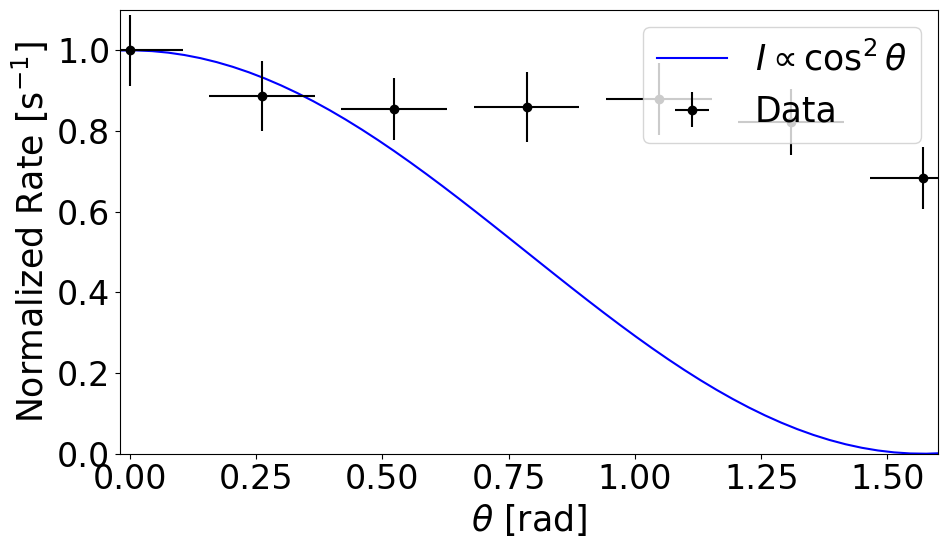

In [6]:
c = anglePlot(angles = [0,15,30,45,60,75,90],
    count_rates = [a1.count_rate,a2.count_rate,a3.count_rate,a4.count_rate,a5.count_rate,a6.count_rate,a7.count_rate],
    count_rates_err = [a1.count_rate_err,a2.count_rate_err,a3.count_rate_err,a4.count_rate_err,a5.count_rate_err,a6.count_rate_err,a7.count_rate_err],
    figsize = [10,6],fontsize = 25, alpha = 0.9,
    pdf_name='')